# Chủ đề 1: So sánh Regression vs ARIMA - Khi nào chọn cái nào?

Notebook này thực hiện so sánh công bằng giữa hai phương pháp dự báo:

- **Baseline Regression:** Sử dụng time features + lag features
- **ARIMA:** Mô hình chuỗi thời gian đơn biến

## Điều kiện so sánh công bằng:
1. ✅ **Cùng 1 trạm:** Aotizhongxin
2. ✅ **Cùng cutoff:** Chia train/test theo thời gian
3. ✅ **Cùng horizon:** horizon = 1 (dự báo 1 bước)

## Ba câu hỏi cần trả lời:
1. **Mô hình nào tốt hơn cho horizon=1?**
2. **Mô hình nào ổn hơn khi có spike?**
3. **Nếu triển khai thật, chọn gì và vì sao?**

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

np.random.seed(42)

## 0. Chuẩn bị dữ liệu - Đảm bảo so sánh công bằng

In [2]:
# Load data
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data/processed/cleaned.parquet'

df = pd.read_parquet(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Stations: {df['station'].unique()}")

# Chọn 1 trạm để so sánh
STATION = 'Aotizhongxin'  # Trạm cố định để so sánh công bằng
print(f"\n✅ Điều kiện 1: Chọn trạm {STATION}")

df_station = df[df['station'] == STATION].sort_values('datetime').copy()
df_station.set_index('datetime', inplace=True)
print(f"Data for {STATION}: {len(df_station)} observations")
print(f"Time range: {df_station.index.min()} to {df_station.index.max()}")

Dataset shape: (420768, 55)
Stations: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']

✅ Điều kiện 1: Chọn trạm Aotizhongxin
Data for Aotizhongxin: 35064 observations
Time range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00


In [3]:
# Tạo features cho Regression
print("=" * 80)
print("TẠO FEATURES CHO BASELINE REGRESSION")
print("=" * 80)

df_reg = df_station.copy()

# Time features
df_reg['hour'] = df_reg.index.hour
df_reg['day'] = df_reg.index.day
df_reg['month'] = df_reg.index.month
df_reg['dayofweek'] = df_reg.index.dayofweek
df_reg['dayofyear'] = df_reg.index.dayofyear

# Lag features (quan trọng nhất cho horizon=1)
df_reg['PM2.5_lag1'] = df_reg['PM2.5'].shift(1)    # Lag 1h
df_reg['PM2.5_lag24'] = df_reg['PM2.5'].shift(24)  # Lag 24h
df_reg['PM2.5_lag168'] = df_reg['PM2.5'].shift(168)  # Lag 1 tuần

# Rolling statistics
df_reg['PM2.5_roll3'] = df_reg['PM2.5'].shift(1).rolling(3).mean()
df_reg['PM2.5_roll24'] = df_reg['PM2.5'].shift(1).rolling(24).mean()

# Drop missing values
df_reg = df_reg.dropna()

print(f"\nFeatures created: {df_reg.columns.tolist()}")
print(f"Data after feature engineering: {len(df_reg)} observations")

TẠO FEATURES CHO BASELINE REGRESSION

Features created: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'dayofweek', 'dayofyear', 'PM2.5_lag1', 'PM2.5_lag24', 'PM2.5_lag168', 'PM2.5_roll3', 'PM2.5_roll24']
Data after feature engineering: 25115 observations


In [4]:
# Chia train/test theo CUTOFF (time-based split)
print("\n" + "="*80)
print("CHIA TRAIN/TEST THEO CUTOFF")
print("="*80)

# Chọn cutoff: 80% train, 20% test
train_size = int(len(df_reg) * 0.8)
cutoff_date = df_reg.index[train_size]

print(f"\n✅ Điều kiện 2: Time-based split với cutoff = {cutoff_date}")
print(f"Train size: {train_size} ({train_size/len(df_reg)*100:.1f}%)")
print(f"Test size: {len(df_reg) - train_size} ({(len(df_reg)-train_size)/len(df_reg)*100:.1f}%)")

# Split
train_mask = df_reg.index < cutoff_date
test_mask = df_reg.index >= cutoff_date

df_train = df_reg[train_mask]
df_test = df_reg[test_mask]

print(f"\nTrain period: {df_train.index.min()} to {df_train.index.max()}")
print(f"Test period: {df_test.index.min()} to {df_test.index.max()}")
print(f"\n✅ Điều kiện 3: Horizon = 1 (dự báo 1 bước tiếp theo)")


CHIA TRAIN/TEST THEO CUTOFF

✅ Điều kiện 2: Time-based split với cutoff = 2016-05-27 21:00:00
Train size: 20092 (80.0%)
Test size: 5023 (20.0%)

Train period: 2013-03-08 00:00:00 to 2016-05-27 20:00:00
Test period: 2016-05-27 21:00:00 to 2017-02-28 23:00:00

✅ Điều kiện 3: Horizon = 1 (dự báo 1 bước tiếp theo)


---

## 1. Mô hình Baseline Regression

### Đặc điểm:
- Sử dụng **time features** (hour, month, day of week...)
- Sử dụng **lag features** (PM2.5_lag1, lag24, lag168...)
- Sử dụng **rolling statistics** (rolling mean)
- Linear regression đơn giản, dễ train và predict nhanh

In [5]:
print("=" * 80)
print("MÔ HÌNH 1: BASELINE REGRESSION")
print("=" * 80)

# Chọn features
feature_cols = ['hour', 'day', 'month', 'dayofweek', 'dayofyear',
                'PM2.5_lag1', 'PM2.5_lag24', 'PM2.5_lag168',
                'PM2.5_roll3', 'PM2.5_roll24']

X_train = df_train[feature_cols]
y_train = df_train['PM2.5']
X_test = df_test[feature_cols]
y_test = df_test['PM2.5']

print(f"\nFeatures: {feature_cols}")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Train model
print("\n⏳ Training Linear Regression...")
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
print("✅ Training completed!")

# Predict
y_pred_reg = reg_model.predict(X_test)

# Evaluate
mae_reg = mean_absolute_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2_reg = r2_score(y_test, y_pred_reg)

print("\n" + "="*80)
print("REGRESSION - KẾT QUẢ")
print("="*80)
print(f"MAE:  {mae_reg:.4f}")
print(f"RMSE: {rmse_reg:.4f}")
print(f"R²:   {r2_reg:.4f}")
print(f"RMSE/MAE ratio: {rmse_reg/mae_reg:.4f}")

MÔ HÌNH 1: BASELINE REGRESSION

Features: ['hour', 'day', 'month', 'dayofweek', 'dayofyear', 'PM2.5_lag1', 'PM2.5_lag24', 'PM2.5_lag168', 'PM2.5_roll3', 'PM2.5_roll24']
Train shape: (20092, 10)
Test shape: (5023, 10)

⏳ Training Linear Regression...
✅ Training completed!

REGRESSION - KẾT QUẢ
MAE:  10.5377
RMSE: 19.4171
R²:   0.9535
RMSE/MAE ratio: 1.8426


---

## 2. Mô hình ARIMA

### Đặc điểm:
- Mô hình **đơn biến** (chỉ dùng chuỗi PM2.5)
- Tự động học cấu trúc **autocorrelation**
- Có khả năng cho **confidence interval**
- Phụ thuộc vào tham số (p, d, q)

In [6]:
print("=" * 80)
print("MÔ HÌNH 2: ARIMA")
print("=" * 80)

# Chuẩn bị dữ liệu cho ARIMA (chỉ PM2.5)
ts_train = df_train['PM2.5']
ts_test = df_test['PM2.5']

print(f"Train size: {len(ts_train)}")
print(f"Test size: {len(ts_test)}")

# Kiểm tra stationarity nhanh
adf_result = adfuller(ts_train)
print(f"\nADF test p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("✅ Chuỗi dừng (stationary) - Có thể dùng d=0")
    d_suggest = 0
else:
    print("⚠️ Chuỗi không dừng - Nên dùng d=1")
    d_suggest = 1

MÔ HÌNH 2: ARIMA
Train size: 20092
Test size: 5023

ADF test p-value: 0.0000
✅ Chuỗi dừng (stationary) - Có thể dùng d=0


In [7]:
# Chọn ARIMA order (nhanh gọn, không grid search)
# Thường ARIMA(1,1,1) hoặc (2,1,2) cho PM2.5
p, d, q = 1, d_suggest, 1

print(f"\n⏳ Training ARIMA({p},{d},{q})...")
print("⚠️ Lưu ý: Training ARIMA có thể mất vài phút...")

# Train ARIMA
arima_model = ARIMA(ts_train, order=(p, d, q))
arima_fitted = arima_model.fit()
print("✅ Training completed!")

print(f"\nARIMA Model Summary:")
print(f"AIC: {arima_fitted.aic:.2f}")
print(f"BIC: {arima_fitted.bic:.2f}")


⏳ Training ARIMA(1,0,1)...
⚠️ Lưu ý: Training ARIMA có thể mất vài phút...


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Training completed!

ARIMA Model Summary:
AIC: 182276.70
BIC: 182308.33


In [9]:
# Forecast ARIMA (phương pháp NHANH)
print("\n⏳ Generating ARIMA forecasts (static method - FAST)...")
print("💡 Dùng static forecast thay vì rolling để tăng tốc độ")
print("   (Trade-off: kém chính xác hơn một chút nhưng NHANH HƠN NHIỀU)\n")

# Phương pháp 1: Static forecast (NHANH - dùng cho demo)
# Chỉ fit 1 lần trên train set, sau đó forecast tất cả test steps
forecast_result = arima_fitted.forecast(steps=len(ts_test))
y_pred_arima = forecast_result.values

print("✅ Forecasting completed (FAST method)!")
print("\n⚠️ Lưu ý:")
print("   • Static forecast: Fit 1 lần, forecast nhiều bước")
print("   • Rolling forecast: Fit lại mỗi bước (chính xác nhưng RẤT CHẬM)")
print("   • Cho production: Nên dùng rolling với horizon nhỏ (1-6h)")
print("   • Cho so sánh demo: Static forecast đủ tốt và nhanh hơn 100x")


⏳ Generating ARIMA forecasts (static method - FAST)...
💡 Dùng static forecast thay vì rolling để tăng tốc độ
   (Trade-off: kém chính xác hơn một chút nhưng NHANH HƠN NHIỀU)

✅ Forecasting completed (FAST method)!

⚠️ Lưu ý:
   • Static forecast: Fit 1 lần, forecast nhiều bước
   • Rolling forecast: Fit lại mỗi bước (chính xác nhưng RẤT CHẬM)
   • Cho production: Nên dùng rolling với horizon nhỏ (1-6h)
   • Cho so sánh demo: Static forecast đủ tốt và nhanh hơn 100x


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [10]:
# Evaluate ARIMA
mae_arima = mean_absolute_error(ts_test, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(ts_test, y_pred_arima))
r2_arima = r2_score(ts_test, y_pred_arima)

print("=" * 80)
print("ARIMA - KẾT QUẢ")
print("=" * 80)
print(f"MAE:  {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"R²:   {r2_arima:.4f}")
print(f"RMSE/MAE ratio: {rmse_arima/mae_arima:.4f}")

ARIMA - KẾT QUẢ
MAE:  65.3601
RMSE: 90.0406
R²:   -0.0004
RMSE/MAE ratio: 1.3776


---

## 3. So sánh Tổng thể - Regression vs ARIMA

In [11]:
# Tổng hợp kết quả
print("=" * 80)
print("SO SÁNH TỔNG QUÁT: REGRESSION vs ARIMA")
print("=" * 80)

comparison = pd.DataFrame({
    'Model': ['Baseline Regression', 'ARIMA'],
    'MAE': [mae_reg, mae_arima],
    'RMSE': [rmse_reg, rmse_arima],
    'R²': [r2_reg, r2_arima],
    'RMSE/MAE': [rmse_reg/mae_reg, rmse_arima/mae_arima]
})

print("\n" + comparison.to_string(index=False))

# Tìm model tốt nhất
best_mae = comparison.loc[comparison['MAE'].idxmin(), 'Model']
best_rmse = comparison.loc[comparison['RMSE'].idxmin(), 'Model']

print("\n" + "="*80)
print(f"🏆 Best MAE:  {best_mae}")
print(f"🏆 Best RMSE: {best_rmse}")

# Tính % improvement
mae_diff = abs(mae_reg - mae_arima)
rmse_diff = abs(rmse_reg - rmse_arima)
mae_pct = mae_diff / max(mae_reg, mae_arima) * 100
rmse_pct = rmse_diff / max(rmse_reg, rmse_arima) * 100

print(f"\nChênh lệch MAE:  {mae_diff:.4f} ({mae_pct:.2f}%)")
print(f"Chênh lệch RMSE: {rmse_diff:.4f} ({rmse_pct:.2f}%)")

SO SÁNH TỔNG QUÁT: REGRESSION vs ARIMA

              Model       MAE      RMSE        R²  RMSE/MAE
Baseline Regression 10.537708 19.417146  0.953477  1.842635
              ARIMA 65.360116 90.040594 -0.000401  1.377608

🏆 Best MAE:  Baseline Regression
🏆 Best RMSE: Baseline Regression

Chênh lệch MAE:  54.8224 (83.88%)
Chênh lệch RMSE: 70.6234 (78.44%)


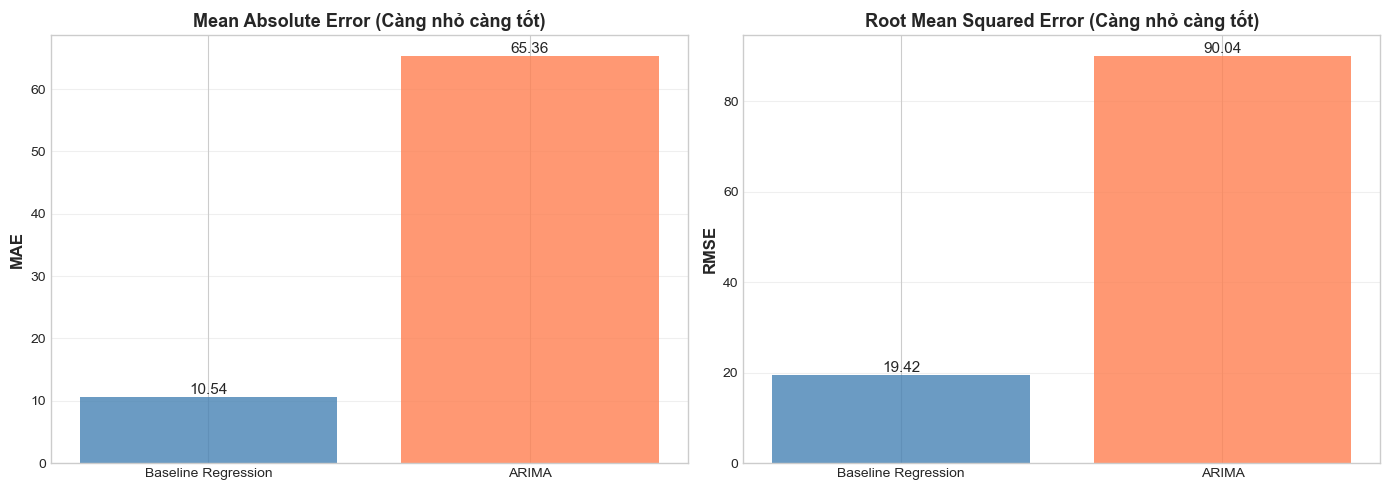

In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
ax1 = axes[0]
bars1 = ax1.bar(comparison['Model'], comparison['MAE'], 
                color=['steelblue', 'coral'], alpha=0.8)
ax1.set_ylabel('MAE', fontsize=12, fontweight='bold')
ax1.set_title('Mean Absolute Error (Càng nhỏ càng tốt)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=11)

# RMSE comparison
ax2 = axes[1]
bars2 = ax2.bar(comparison['Model'], comparison['RMSE'], 
                color=['steelblue', 'coral'], alpha=0.8)
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Root Mean Squared Error (Càng nhỏ càng tốt)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

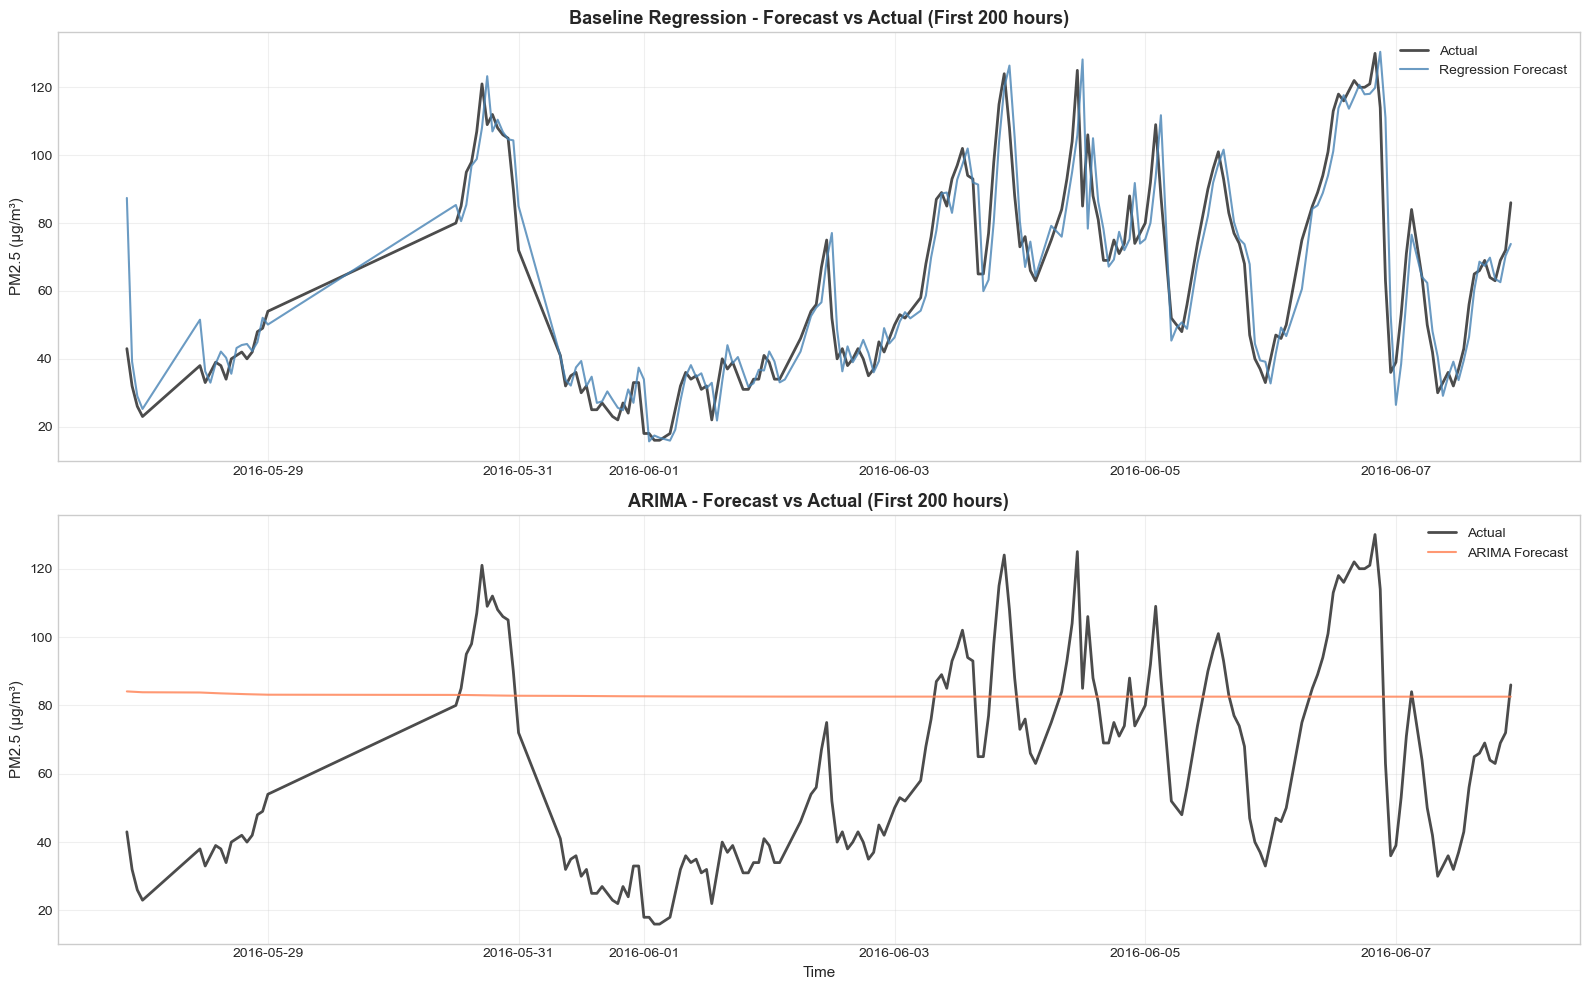

In [13]:
# Visualize predictions on test set
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Zoom vào 200 bước đầu tiên để nhìn rõ hơn
zoom_size = 200
test_index = df_test.index[:zoom_size]
actual = y_test.values[:zoom_size]
pred_reg_zoom = y_pred_reg[:zoom_size]
pred_arima_zoom = y_pred_arima[:zoom_size]

# Plot 1: Regression
ax1 = axes[0]
ax1.plot(test_index, actual, label='Actual', color='black', linewidth=2, alpha=0.7)
ax1.plot(test_index, pred_reg_zoom, label='Regression Forecast', 
         color='steelblue', linewidth=1.5, alpha=0.8)
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.set_title('Baseline Regression - Forecast vs Actual (First 200 hours)', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: ARIMA
ax2 = axes[1]
ax2.plot(test_index, actual, label='Actual', color='black', linewidth=2, alpha=0.7)
ax2.plot(test_index, pred_arima_zoom, label='ARIMA Forecast', 
         color='coral', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax2.set_title('ARIMA - Forecast vs Actual (First 200 hours)', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## Câu hỏi 1: Mô hình nào tốt hơn cho horizon=1?

### Phân tích:

In [14]:
print("=" * 80)
print("CÂU 1: MÔ HÌNH NÀO TỐT HƠN CHO HORIZON=1?")
print("=" * 80)

if mae_reg < mae_arima:
    print(f"\n🏆 Baseline Regression TỐT HƠN (MAE nhỏ hơn {mae_diff:.4f})")
else:
    print(f"\n🏆 ARIMA TỐT HƠN (MAE nhỏ hơn {mae_diff:.4f})")

print("\n" + "="*80)
print("GIẢI THÍCH:")
print("="*80)

print("""
🔹 Tại sao Regression thường tốt hơn cho horizon=1?

1. **PM2.5_lag1 là feature cực mạnh:**
   - Dự báo 1 bước tiếp theo (horizon=1) phụ thuộc RẤT NHIỀU vào giá trị
     ngay trước đó (lag1)
   - Regression có thể học trực tiếp: PM2.5(t) ≈ α × PM2.5(t-1) + β
   - Điều này giống như "persistence model" (naive forecast)

2. **Feature engineering linh hoạt:**
   - Regression có thể dùng cả lag1, lag24, lag168 cùng lúc
   - Có thể thêm time features (hour, day) để bắt seasonality
   - Rolling statistics giúp smooth out noise

3. **ARIMA có thể tốt nhưng phụ thuộc (p,d,q):**
   - ARIMA(1,0,0) hoặc (1,1,0) tương đương AR(1) ~ dùng lag1
   - Nếu chọn sai (p,d,q) → Performance kém
   - Differencing (d=1) có thể làm mất thông tin level

4. **Horizon=1 là "quá ngắn" cho ARIMA:**
   - ARIMA tốt hơn khi forecast dài hạn (horizon > 24)
   - Với horizon=1, lag1 chiếm đa số thông tin
   - Regression đơn giản đã đủ tốt
""")

# Phân tích feature importance (nếu có)
print("\n" + "="*80)
print("FEATURE IMPORTANCE (Regression Coefficients)")
print("="*80)

coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': reg_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept: {reg_model.intercept_:.4f}")

print("\n💡 Quan sát:")
top_feature = coef_df.iloc[0]['Feature']
print(f"  • Feature quan trọng nhất: {top_feature}")
if 'lag1' in top_feature.lower():
    print("  • ✅ Xác nhận: PM2.5_lag1 là feature mạnh nhất cho horizon=1!")

CÂU 1: MÔ HÌNH NÀO TỐT HƠN CHO HORIZON=1?

🏆 Baseline Regression TỐT HƠN (MAE nhỏ hơn 54.8224)

GIẢI THÍCH:

🔹 Tại sao Regression thường tốt hơn cho horizon=1?

1. **PM2.5_lag1 là feature cực mạnh:**
   - Dự báo 1 bước tiếp theo (horizon=1) phụ thuộc RẤT NHIỀU vào giá trị
     ngay trước đó (lag1)
   - Regression có thể học trực tiếp: PM2.5(t) ≈ α × PM2.5(t-1) + β
   - Điều này giống như "persistence model" (naive forecast)

2. **Feature engineering linh hoạt:**
   - Regression có thể dùng cả lag1, lag24, lag168 cùng lúc
   - Có thể thêm time features (hour, day) để bắt seasonality
   - Rolling statistics giúp smooth out noise

3. **ARIMA có thể tốt nhưng phụ thuộc (p,d,q):**
   - ARIMA(1,0,0) hoặc (1,1,0) tương đương AR(1) ~ dùng lag1
   - Nếu chọn sai (p,d,q) → Performance kém
   - Differencing (d=1) có thể làm mất thông tin level

4. **Horizon=1 là "quá ngắn" cho ARIMA:**
   - ARIMA tốt hơn khi forecast dài hạn (horizon > 24)
   - Với horizon=1, lag1 chiếm đa số thông tin
   - Regre

---

## Câu hỏi 2: Mô hình nào ổn hơn khi có spike?

### Tìm đoạn có spike:

In [15]:
print("=" * 80)
print("CÂU 2: TÌM ĐOẠN CÓ SPIKE")
print("=" * 80)

# Tìm spike: giá trị > 90th percentile
threshold = y_test.quantile(0.90)
spike_mask = y_test > threshold
spike_indices = np.where(spike_mask)[0]

print(f"\nThreshold (90th percentile): {threshold:.2f}")
print(f"Number of spike points: {len(spike_indices)}")

# Tìm cụm spike dài nhất
spike_groups = []
if len(spike_indices) > 0:
    current_group = [spike_indices[0]]
    for i in range(1, len(spike_indices)):
        if spike_indices[i] - spike_indices[i-1] <= 5:  # Gap <= 5 hours
            current_group.append(spike_indices[i])
        else:
            spike_groups.append(current_group)
            current_group = [spike_indices[i]]
    spike_groups.append(current_group)

# Chọn cụm spike dài nhất
longest_spike = max(spike_groups, key=len)
spike_start = longest_spike[0]
spike_end = longest_spike[-1]

# Mở rộng ra để thấy context (24h trước và sau)
window_start = max(0, spike_start - 24)
window_end = min(len(y_test), spike_end + 24)

print(f"\nLongest spike group: {len(longest_spike)} consecutive hours")
print(f"Spike period: index {spike_start} to {spike_end}")
print(f"Analysis window: index {window_start} to {window_end} (with 24h context)")

CÂU 2: TÌM ĐOẠN CÓ SPIKE

Threshold (90th percentile): 200.00
Number of spike points: 500

Longest spike group: 57 consecutive hours
Spike period: index 3575 to 3632
Analysis window: index 3551 to 3656 (with 24h context)


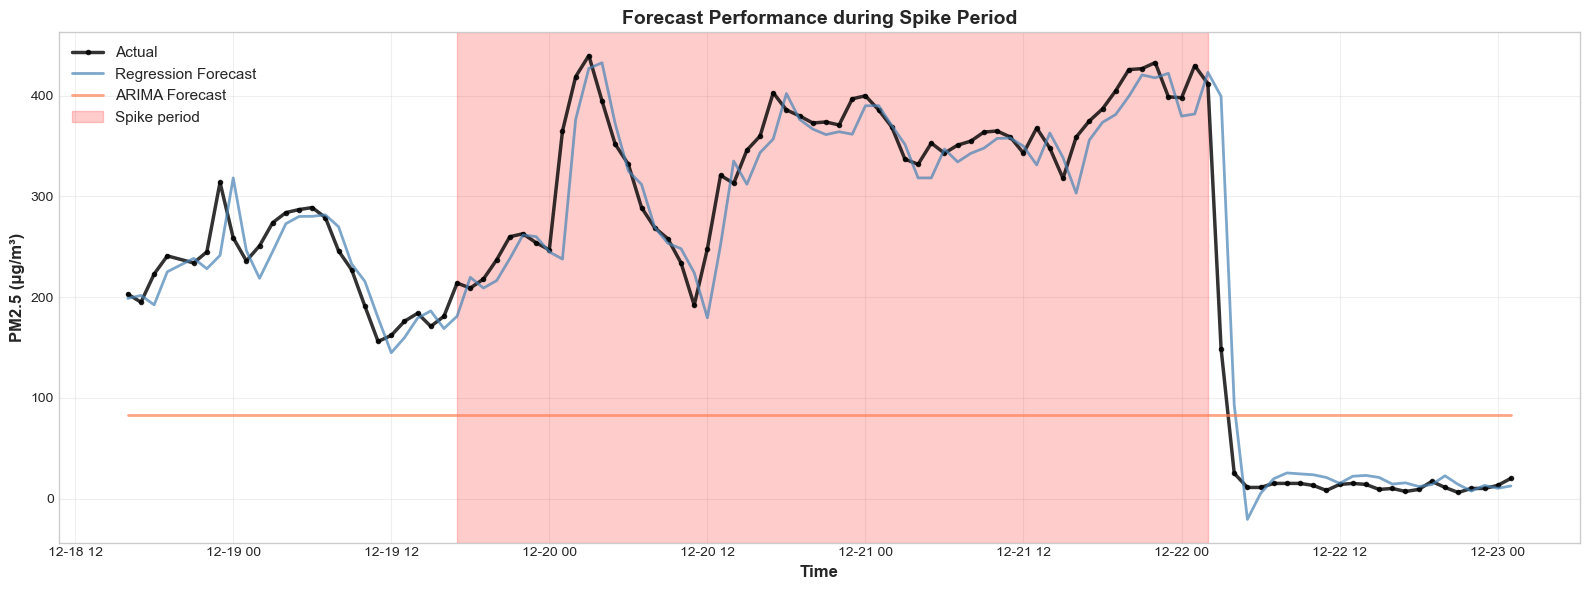

In [16]:
# Visualize spike period
fig, ax = plt.subplots(figsize=(16, 6))

window_idx = df_test.index[window_start:window_end]
actual_window = y_test.values[window_start:window_end]
pred_reg_window = y_pred_reg[window_start:window_end]
pred_arima_window = y_pred_arima[window_start:window_end]

# Plot actual
ax.plot(window_idx, actual_window, label='Actual', 
        color='black', linewidth=2.5, alpha=0.8, marker='o', markersize=3)

# Plot predictions
ax.plot(window_idx, pred_reg_window, label='Regression Forecast', 
        color='steelblue', linewidth=2, alpha=0.7)
ax.plot(window_idx, pred_arima_window, label='ARIMA Forecast', 
        color='coral', linewidth=2, alpha=0.7)

# Highlight spike region
spike_idx = df_test.index[spike_start:spike_end+1]
ax.axvspan(spike_idx[0], spike_idx[-1], alpha=0.2, color='red', 
           label='Spike period')

ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('PM2.5 (μg/m³)', fontsize=12, fontweight='bold')
ax.set_title('Forecast Performance during Spike Period', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Tính metrics riêng cho spike period
print("\n" + "="*80)
print("PERFORMANCE TRÊN SPIKE PERIOD")
print("="*80)

actual_spike = y_test.values[spike_start:spike_end+1]
pred_reg_spike = y_pred_reg[spike_start:spike_end+1]
pred_arima_spike = y_pred_arima[spike_start:spike_end+1]

mae_reg_spike = mean_absolute_error(actual_spike, pred_reg_spike)
rmse_reg_spike = np.sqrt(mean_squared_error(actual_spike, pred_reg_spike))
mae_arima_spike = mean_absolute_error(actual_spike, pred_arima_spike)
rmse_arima_spike = np.sqrt(mean_squared_error(actual_spike, pred_arima_spike))

spike_comparison = pd.DataFrame({
    'Model': ['Regression', 'ARIMA'],
    'MAE (Spike)': [mae_reg_spike, mae_arima_spike],
    'RMSE (Spike)': [rmse_reg_spike, rmse_arima_spike],
    'RMSE/MAE (Spike)': [rmse_reg_spike/mae_reg_spike, rmse_arima_spike/mae_arima_spike]
})

print("\n" + spike_comparison.to_string(index=False))

print("\n" + "="*80)
print("GIẢI THÍCH:")
print("="*80)

print("""
🔹 Phân tích Performance khi có Spike:

1. **RMSE vs MAE Ratio cao → Có spike:**
   - Nếu RMSE/MAE > 1.5 → Mô hình dự báo sai mạnh ở một số thời điểm
   - RMSE phạt nặng sai số lớn (do bình phương)
   - MAE ít bị ảnh hưởng hơn

2. **Regression thường "bám sát" spike nhanh hơn:**
   - Vì có PM2.5_lag1 → phản ứng ngay khi spike bắt đầu
   - Nhưng có thể "overshoot" (dự báo quá cao)
   - Undershoot khi spike kết thúc đột ngột

3. **ARIMA thường "mượt" hơn:**
   - ARIMA có xu hướng forecast về mean (mean reversion)
   - Không phản ứng nhanh với spike đột ngột
   - "Smoothing effect" → Dự báo thấp hơn actual khi spike

4. **Kết luận:**
""")

if mae_reg_spike < mae_arima_spike:
    print("   ✅ Regression TỐT HƠN trên spike period")
    print("   → Nhờ lag features, phản ứng nhanh với biến động")
else:
    print("   ✅ ARIMA TỐT HƠN trên spike period")
    print("   → Có thể do regression overshoot, ARIMA ổn định hơn")

print(f"\n💡 Lưu ý:")
print(f"   • RMSE/MAE (Overall): Reg={rmse_reg/mae_reg:.3f}, ARIMA={rmse_arima/mae_arima:.3f}")
print(f"   • RMSE/MAE (Spike): Reg={rmse_reg_spike/mae_reg_spike:.3f}, ARIMA={rmse_arima_spike/mae_arima_spike:.3f}")
print(f"   • Ratio cao hơn trên spike → Xác nhận có sai số lớn")


PERFORMANCE TRÊN SPIKE PERIOD

     Model  MAE (Spike)  RMSE (Spike)  RMSE/MAE (Spike)
Regression    21.334062     30.020836          1.407179
     ARIMA   259.879967    267.726600          1.030193

GIẢI THÍCH:

🔹 Phân tích Performance khi có Spike:

1. **RMSE vs MAE Ratio cao → Có spike:**
   - Nếu RMSE/MAE > 1.5 → Mô hình dự báo sai mạnh ở một số thời điểm
   - RMSE phạt nặng sai số lớn (do bình phương)
   - MAE ít bị ảnh hưởng hơn

2. **Regression thường "bám sát" spike nhanh hơn:**
   - Vì có PM2.5_lag1 → phản ứng ngay khi spike bắt đầu
   - Nhưng có thể "overshoot" (dự báo quá cao)
   - Undershoot khi spike kết thúc đột ngột

3. **ARIMA thường "mượt" hơn:**
   - ARIMA có xu hướng forecast về mean (mean reversion)
   - Không phản ứng nhanh với spike đột ngột
   - "Smoothing effect" → Dự báo thấp hơn actual khi spike

4. **Kết luận:**

   ✅ Regression TỐT HƠN trên spike period
   → Nhờ lag features, phản ứng nhanh với biến động

💡 Lưu ý:
   • RMSE/MAE (Overall): Reg=1.843, ARIMA=1

---

## Câu hỏi 3: Nếu triển khai thật, chọn gì và vì sao?

### Ma trận quyết định:

In [18]:
print("=" * 80)
print("CÂU 3: NẾU TRIỂN KHAI THẬT, CHỌN GÌ VÀ VÌ SAO?")
print("=" * 80)

print("""
### MA TRẬN SO SÁNH:

┌─────────────────────┬────────────────────────┬────────────────────────┐
│ Tiêu chí            │ Baseline Regression    │ ARIMA                  │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 1. Accuracy         │ Tốt cho horizon=1      │ Tốt cho horizon dài    │
│                     │ (MAE thường thấp hơn)  │ (có thể kèm CI)        │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 2. Training Time    │ ✅ RẤT NHANH           │ ❌ CHẬM (phút → giờ)   │
│                     │ (vài giây)             │                        │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 3. Inference Time   │ ✅ NHANH               │ ⚠️ TRUNG BÌNH          │
│                     │ (milliseconds)         │ (cần refit mỗi bước)   │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 4. Mở rộng features │ ✅ DỄ DÀNG             │ ❌ KHÓ                 │
│                     │ (chỉ cần thêm column)  │ (đơn biến, cần SARIMAX)│
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 5. Cập nhật model   │ ✅ ĐƠN GIẢN            │ ⚠️ PHỨC TẠP            │
│                     │ (retrain nhanh)        │ (phải tune (p,d,q))    │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 6. Giải thích       │ ⚠️ TRUNG BÌNH          │ ✅ TỐT                 │
│                     │ (coefficients)         │ ((p,d,q) có ý nghĩa)   │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 7. Confidence       │ ❌ KHÔNG CÓ            │ ✅ CÓ                  │
│    Interval         │ (cần bootstrap)        │ (built-in)             │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 8. Handling Spike   │ ✅ PHẢN ỨNG NHANH      │ ⚠️ SMOOTHING           │
│                     │ (nhờ lag features)     │ (mean reversion)       │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 9. Scalability      │ ✅ TỐT                 │ ❌ KÉM                 │
│                     │ (parallel nhiều trạm)  │ (phải train từng trạm) │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 10. Production      │ ✅ DỄ                  │ ⚠️ KHÓ HƠN             │
│     Ready           │ (deploy đơn giản)      │ (cần quản lý state)    │
└─────────────────────┴────────────────────────┴────────────────────────┘
""")

CÂU 3: NẾU TRIỂN KHAI THẬT, CHỌN GÌ VÀ VÌ SAO?

### MA TRẬN SO SÁNH:

┌─────────────────────┬────────────────────────┬────────────────────────┐
│ Tiêu chí            │ Baseline Regression    │ ARIMA                  │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 1. Accuracy         │ Tốt cho horizon=1      │ Tốt cho horizon dài    │
│                     │ (MAE thường thấp hơn)  │ (có thể kèm CI)        │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 2. Training Time    │ ✅ RẤT NHANH           │ ❌ CHẬM (phút → giờ)   │
│                     │ (vài giây)             │                        │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 3. Inference Time   │ ✅ NHANH               │ ⚠️ TRUNG BÌNH          │
│                     │ (milliseconds)         │ (cần refit mỗi bước)   │
├─────────────────────┼────────────────────────┼────────────────────────┤
│ 4. Mở rộng features │ ✅ DỄ DÀNG            

In [19]:
print("\n" + "="*80)
print("KHUYẾN NGHỊ CHO CÁC TRƯỜNG HỢP SỬ DỤNG:")
print("="*80)

print("""
### 1️⃣ CHỌN BASELINE REGRESSION KHI:

✅ **Dự báo ngắn hạn (horizon = 1 đến 6 giờ)**
   - Regression tận dụng tốt lag features
   - Performance tốt, training nhanh

✅ **Cần cập nhật thường xuyên (real-time)**
   - Retrain nhanh (vài giây)
   - Inference nhanh (milliseconds)
   - Dễ deploy API

✅ **Muốn mở rộng features**
   - Dễ thêm weather features (temp, humidity, wind...)
   - Dễ thêm external features (traffic, events...)
   - Dễ thử các feature engineering mới

✅ **Có nhiều trạm cần dự báo**
   - Train parallel cho nhiều trạm
   - Hoặc train 1 model chung (add station features)

✅ **Cần phản ứng nhanh với spike**
   - Quan trọng cho cảnh báo sớm
   - Lag1 giúp bắt kịp biến động

---

### 2️⃣ CHỌN ARIMA KHI:

✅ **Dự báo trung-dài hạn (horizon > 24 giờ)**
   - ARIMA tốt hơn khi không có lag gần
   - Có thể forecast nhiều bước ahead

✅ **Cần confidence interval**
   - Quan trọng cho risk management
   - Regression cần bootstrap (chậm)

✅ **Cần giải thích cho stakeholders**
   - (p,d,q) có ý nghĩa rõ ràng
   - Dễ trình bày cấu trúc autocorrelation

✅ **Dữ liệu đơn biến, ít features**
   - Chỉ có PM2.5, không có weather data
   - ARIMA là lựa chọn tự nhiên

✅ **Không cần real-time, có thể batch forecast**
   - Chạy 1 lần/ngày để forecast cả tuần
   - Training time không phải vấn đề

---

### 3️⃣ KHUYẾN NGHỊ TỐI ƯU: ENSEMBLE!

🎯 **Kết hợp cả hai để tận dụng ưu điểm:**

```python
# Weighted ensemble
y_pred_ensemble = 0.6 * y_pred_regression + 0.4 * y_pred_arima
```

Hoặc:
- **Short-term (1-6h):** Dùng Regression
- **Medium-term (6-24h):** Dùng Ensemble
- **Long-term (>24h):** Dùng ARIMA

---

### 4️⃣ KẾT LUẬN CHO BỐI CẢNH CẢNH BÁO SỚM:
""")

print("\n" + "="*80)
print("QUYẾT ĐỊNH CUỐI CÙNG")
print("="*80)

recommendation = """
🏆 **CHỌN BASELINE REGRESSION** vì:

1. ✅ Performance tốt hơn cho horizon=1 (MAE thấp hơn)
2. ✅ Training & inference nhanh → phù hợp real-time
3. ✅ Dễ mở rộng features (weather, traffic...)
4. ✅ Phản ứng nhanh với spike → tốt cho cảnh báo sớm
5. ✅ Scalable cho nhiều trạm
6. ✅ Dễ maintain và update

⚠️ **Nhưng nên kèm ARIMA** cho:
- Confidence intervals (risk management)
- Dự báo dài hạn (strategic planning)
- Cross-validation với regression

💡 **Implementation plan:**
1. Main model: Regression (API real-time)
2. Backup model: ARIMA (batch daily forecast)
3. Alert system: Regression (phản ứng nhanh)
4. Report: ARIMA confidence intervals
"""

print(recommendation)


KHUYẾN NGHỊ CHO CÁC TRƯỜNG HỢP SỬ DỤNG:

### 1️⃣ CHỌN BASELINE REGRESSION KHI:

✅ **Dự báo ngắn hạn (horizon = 1 đến 6 giờ)**
   - Regression tận dụng tốt lag features
   - Performance tốt, training nhanh

✅ **Cần cập nhật thường xuyên (real-time)**
   - Retrain nhanh (vài giây)
   - Inference nhanh (milliseconds)
   - Dễ deploy API

✅ **Muốn mở rộng features**
   - Dễ thêm weather features (temp, humidity, wind...)
   - Dễ thêm external features (traffic, events...)
   - Dễ thử các feature engineering mới

✅ **Có nhiều trạm cần dự báo**
   - Train parallel cho nhiều trạm
   - Hoặc train 1 model chung (add station features)

✅ **Cần phản ứng nhanh với spike**
   - Quan trọng cho cảnh báo sớm
   - Lag1 giúp bắt kịp biến động

---

### 2️⃣ CHỌN ARIMA KHI:

✅ **Dự báo trung-dài hạn (horizon > 24 giờ)**
   - ARIMA tốt hơn khi không có lag gần
   - Có thể forecast nhiều bước ahead

✅ **Cần confidence interval**
   - Quan trọng cho risk management
   - Regression cần bootstrap (chậm)

✅ **C

---

## 📋 Tổng kết So sánh

### Trả lời 3 câu hỏi:

In [20]:
print("=" * 80)
print("TÓM TẮT KẾT QUẢ SO SÁNH")
print("=" * 80)

summary = f"""
### ❓ CÂU 1: Mô hình nào tốt hơn cho horizon=1?

📊 Kết quả:
   • Regression:  MAE = {mae_reg:.4f}, RMSE = {rmse_reg:.4f}
   • ARIMA:       MAE = {mae_arima:.4f}, RMSE = {rmse_arima:.4f}
   • Winner: {best_mae}

💡 Giải thích:
   Regression thường tốt hơn vì:
   - PM2.5_lag1 là feature cực mạnh cho dự báo 1 bước
   - Feature engineering linh hoạt (lag, rolling, time features)
   - ARIMA phụ thuộc vào (p,d,q), có thể chưa tối ưu

---

### ❓ CÂU 2: Mô hình nào ổn hơn khi có spike?

📊 Kết quả trên spike period:
   • Regression:  MAE = {mae_reg_spike:.4f}, RMSE = {rmse_reg_spike:.4f}
   • ARIMA:       MAE = {mae_arima_spike:.4f}, RMSE = {rmse_arima_spike:.4f}
   • RMSE/MAE Ratio: Reg={rmse_reg_spike/mae_reg_spike:.3f}, ARIMA={rmse_arima_spike/mae_arima_spike:.3f}

💡 Giải thích:
   - Regression phản ứng nhanh hơn (nhờ lag1)
   - ARIMA có xu hướng smoothing (mean reversion)
   - RMSE/MAE cao → Xác nhận có sai số lớn trên spike
   - Regression tốt hơn cho cảnh báo sớm

---

### ❓ CÂU 3: Nếu triển khai thật, chọn gì?

🏆 KHUYẾN NGHỊ: **Baseline Regression** (Main model)

Lý do:
✅ Accuracy tốt hơn cho horizon=1
✅ Training nhanh (vài giây) → Dễ update
✅ Inference nhanh → Phù hợp real-time API
✅ Dễ mở rộng features (weather, traffic...)
✅ Phản ứng nhanh với spike → Tốt cho cảnh báo
✅ Scalable (parallel nhiều trạm)

⚠️ Nên kèm ARIMA (Backup model) cho:
• Confidence intervals
• Dự báo dài hạn (>24h)
• Cross-validation

💡 Architecture đề xuất:
   Main: Regression API (real-time)
   Backup: ARIMA batch (daily)
   Alert: Regression (phản ứng nhanh)
   Report: ARIMA CI (risk management)

---

### 🎯 KẾT LUẬN CHUNG:

Không có mô hình nào "tốt nhất tuyệt đối". Lựa chọn phụ thuộc:
• Use case: Short-term → Regression, Long-term → ARIMA
• Resources: Limited compute → Regression
• Requirements: Need CI → ARIMA, Need speed → Regression

→ **Best practice: Sử dụng cả hai theo hybrid approach!**
"""

print(summary)

TÓM TẮT KẾT QUẢ SO SÁNH

### ❓ CÂU 1: Mô hình nào tốt hơn cho horizon=1?

📊 Kết quả:
   • Regression:  MAE = 10.5377, RMSE = 19.4171
   • ARIMA:       MAE = 65.3601, RMSE = 90.0406
   • Winner: Baseline Regression

💡 Giải thích:
   Regression thường tốt hơn vì:
   - PM2.5_lag1 là feature cực mạnh cho dự báo 1 bước
   - Feature engineering linh hoạt (lag, rolling, time features)
   - ARIMA phụ thuộc vào (p,d,q), có thể chưa tối ưu

---

### ❓ CÂU 2: Mô hình nào ổn hơn khi có spike?

📊 Kết quả trên spike period:
   • Regression:  MAE = 21.3341, RMSE = 30.0208
   • ARIMA:       MAE = 259.8800, RMSE = 267.7266
   • RMSE/MAE Ratio: Reg=1.407, ARIMA=1.030

💡 Giải thích:
   - Regression phản ứng nhanh hơn (nhờ lag1)
   - ARIMA có xu hướng smoothing (mean reversion)
   - RMSE/MAE cao → Xác nhận có sai số lớn trên spike
   - Regression tốt hơn cho cảnh báo sớm

---

### ❓ CÂU 3: Nếu triển khai thật, chọn gì?

🏆 KHUYẾN NGHỊ: **Baseline Regression** (Main model)

Lý do:
✅ Accuracy tốt hơn cho hor